# Figure 7. Intensity-Duration-Frequency (IDF) curvers for large metropolitan areas

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.ticker import FormatStrFormatter
import xarray as xr
import netCDF4 as nc4
import string

import warnings
warnings.filterwarnings('ignore')

font = {'size'   : 10}
mpl.rc('font', **font)

colors_list = [
    '#845ec2', # 0: purple
    '#ff6f91', # 1: pink
    '#3ea2e0', # 2: blue
    '#008000', # 3: green
    '#ffa500', # 4: orange
    '#c5261b'  # 5: red
]

In [2]:
# Functions
def get_noaa_atlas_14_pfe(lat, lon, dtp='depth', unt='metric', tst='pds', whc=''):
    
    """
    Retrieve point precipitation frequency estimate based on 
    the NOAA Atlas 14 for the CONUS in Pandas Data Frame format

    'whc': which data {
            'mean':'mean value', ## skip = 13
            'uppr':'upper bound of 90% ci', ## skip = 13 
            'lwr':'lower bound of 90% ci', ## skip = 13
            '':'all three' ## skip = 13, 35(upper), 57(lower)
            }
            
    'lat': latitude in decimal degrees
    'lon': longitude in decimal degrees
    'tpr': type of precipitation {'pf':'precipitation', 'rf':'rainfall'}
    'dtp': data type ['depth', 'intensity']
    'tst': time series type {'pds': , 'ams':}
    'unt': units of the estimates ['english', 'metric']

    """

    # Test data
#     lat = 37.4
#     lon = -119.2
#     dtp = 'depth'
#     unt = 'metric'
#     tst = 'pds'
#     whc = ''
    
    if whc == '':
        url = f"https://hdsc.nws.noaa.gov/cgi-bin/hdsc/new/fe_text.csv?lat={lat}&lon={lon}&data={dtp}&units={unt}&series={tst}"

        bounds = {13:'mean', 35:'upper', 57:'lower'}
        df = pd.DataFrame()
        for skip in [13, 57, 35]:
            df_add = pd.read_csv(url, sep=',', skiprows=skip, encoding='cp1252')[:19]
            df_add['bound'] = bounds[skip]
            df = df.append(df_add)
        df.index.name='old_index'
        df.reset_index(inplace=True)
    else:
        url = f"https://hdsc.nws.noaa.gov/cgi-bin/hdsc/new/fe_text_{whc}.csv?lat={lat}&lon={lon}&data={dtp}&units={unt}&series={tst}"
        skip = 13
        df = pd.read_csv(url, sep=',', skiprows=skip)[:19]
    
    return df

def find_nearest(array, value):
    """
    Find the neareast value in an array. 
    Return the value or the index (change return line).
    """
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    #return array[idx]
    return idx

## Figure

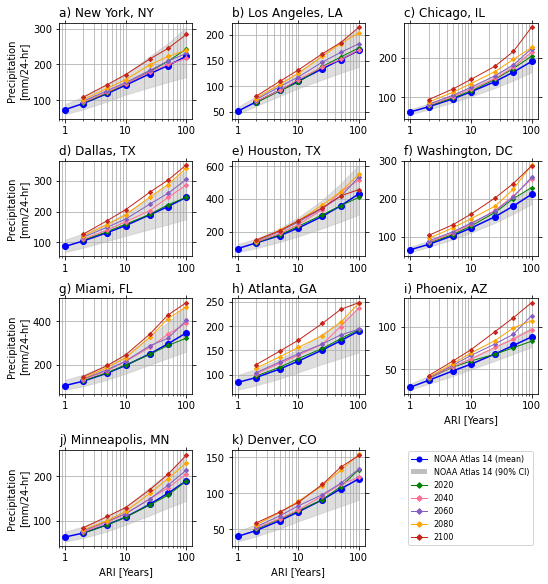

In [3]:
colors_period = [
    #'#3ea2e0', # 2: blue current
    'blue',
    '#008000', # 3: green 2020
    '#ff6f91', # 1: pink 2040
    '#845ec2', # 0: purple 2060
    '#ffa500', # 4: orange 2080
    '#c5261b'  # 5: red 2100
]

# Map - States and Cities
df = pd.read_csv('../shp/metroRegions_plot.csv', encoding='cp1252')

# NOAA Atlas 14
path = '../data/NOAAAtlas14_conus_24hr.nc'
ds_atlas14 = xr.open_dataset(path)
ds_atlas14.close()

# GCM relative change dataset
file = '../data/01_Relative-change.nc'
ds = xr.open_dataset(file)
list_period = ds.period.values.tolist()
n_period = len(list_period)

list_ari = ds.ari.values.tolist()
ds.close()

# Plot
Nr=4
Nc=3
fig, ax = plt.subplots(Nr, Nc, figsize=(7.5, 8.0), constrained_layout=True)

i = 0
for row in range(Nr):
    for col in range(Nc):
        #for i in df.index:
        if i < len(df):
            lat = df.loc[i, "Latitude"]
            lon = df.loc[i, "Longitude"]

            # Nearest climate model centroid to target location
            i_lat = find_nearest(ds_atlas14.isel(ari=0).lat.values, lat)
            i_lon = find_nearest(ds_atlas14.isel(ari=0).lon.values, lon)

            # NOAA Atlas 14 at target location
            df_pfe = get_noaa_atlas_14_pfe(lat, lon)
            df_pfe = df_pfe[df_pfe['old_index']==9]
            ari_list = df_pfe.columns[2:-1].tolist()
            xx = [int(x) for x in ari_list][:7]
            yy = np.squeeze(df_pfe[df_pfe['bound']=='mean'].loc[:, ari_list].values)[:7]
            ax[row,col].plot(xx, yy, color=colors_period[0], marker='o', lw=1.5, label='NOAA Atlas 14 (24-hr)')

            y_min = np.squeeze(df_pfe[df_pfe['bound']=='lower'].loc[:, ari_list].values)
            y_max = np.squeeze(df_pfe[df_pfe['bound']=='upper'].loc[:, ari_list].values)
            ax[row,col].fill_between(xx[:7], y_min[:7], y_max[:7], color='#bfbfbf',  
                                     label='NOAA Atlas 14 (90% CI)', alpha=0.5)

           
            # Climate Model Ensemble Members
            for i_period in range(1, n_period):
                dm = ds.isel(lat=i_lat, lon=i_lon, period=i_period).relative_change.values
                ax[row,col].plot(list_ari[1:], (yy*dm)[1:], c=colors_period[i_period], 
                                 marker='D', lw=1, linestyle='-', ms=3,
                                 label=ds.isel(period=i_period).period.values)

            # Formatting
            ax[row,col].set(
                #xlim=(-5,105), 
                xscale='log', 
                #ylim=(-10,310), 
                #yscale='log'
            )
            ax[row,col].xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
            ax[row,col].grid(which='both', linestyle='-')

            ax[row,col].tick_params(
            bottom=True, top=True, left=True, right=True,
                #labelbottom=True, labeltop=True, labelleft=True, labelright=True,
            )

            #if (row > 0):
            title = string.ascii_lowercase[i]+') '+df.loc[i, "City"]
            ax[row,col].set_title(title, loc='left')
            if (col == 0) and (row < Nr-1):
                ax[row,col].set(xlabel='', ylabel='Precipitation\n[mm/24-hr]')
            elif (col == 0) and (row == Nr-1):
                ax[row,col].set(xlabel='ARI [Years]', ylabel='Precipitation\n[mm/24-hr]')
            elif (col > 0) and (row < Nr-2):
                ax[row,col].set(xlabel='', ylabel='')
            elif (col == 1) and (row == Nr-1):
                ax[row,col].set(xlabel='ARI [Years]', ylabel='')
            elif (col == 2) and (row == Nr-2):
                ax[row,col].set(xlabel='ARI [Years]', ylabel='')

            i+=1

        else:
            # Legend
            msize = 10
            legend_elements = [
#                 Line2D([0], [0], lw=0,
#                        label='Current engineering design standard:'),
                Line2D([0], [0], c=colors_period[0], marker='o', lw=1, ms=5,
                       label='NOAA Atlas 14 (mean)'),
                Patch(facecolor='#bfbfbf', lw=0,
                       label='NOAA Atlas 14 (90% CI)'),
#                 Line2D([0], [0], lw=0,
#                        label=''),
#                 Line2D([0], [0], lw=0,
#                        label='Projected IDF curves:'),
                Line2D([0], [0], c=colors_period[1], marker='D', lw=1, ls='-', ms=4, #alpha=0.5,
                       label=str(ds.isel(period=1).period.values)[-4:]),
                Line2D([0], [0], c=colors_period[2], marker='D', lw=1, ls='-', ms=4, #alpha=0.5,
                       label=str(ds.isel(period=2).period.values)[-4:]),
                Line2D([0], [0], c=colors_period[3], marker='D', lw=1, ls='-', ms=4, #alpha=0.5,
                       label=str(ds.isel(period=3).period.values)[-4:]),
                Line2D([0], [0], c=colors_period[4], marker='D', lw=1, ls='-', ms=4, #alpha=0.5,
                       label=str(ds.isel(period=4).period.values)[-4:]),
                Line2D([0], [0], c=colors_period[5], marker='D', lw=1, ls='-', ms=4, #alpha=0.5,
                       label=str(ds.isel(period=5).period.values)[-4:]),
            ]

            ax[row,col].legend(handles=legend_elements, loc='center left', fontsize=8) #, bbox_to_anchor=(1.05,0))
            ax[row,col].axis('off')

plt.show()

In [5]:
fig.savefig(f'../img/Fig-7_IDFs.png', dpi=500, bbox_inches='tight')